# Virtual Metering

Actual well production data was recorded after the well went on production. The production was modelled in Prosper, which attempted to replicate the actual production values in order to better understand the well physics. The Prosper modelling takes a very long time to run, so the sampling frequency was done once daily. Matching a Random Forest model to the actual production is quite straightforward and the calculation time is extremely rapid, so the sampling frequency could easily be increased.

It should be noted, though, that the machine learning model tells us nothing about the actual physical behaviour. A Prosper model could be match and machine learning model could be matched the Prosper production (if this is believed to be correct) thereby yielding more data faster for production monitoring.

In [1]:
# Load common libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
# Load ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Load dataframe
df = pd.read_csv('data/meter_test.csv')

In [4]:
df.head()

,Time,PDHG-P,PDHG-T,WHP,WHT,Qgas,Qcond,Qwater
0,Comments,SLB Gauge,SLB Gauge,Wellhead,Wellhead,MPM Rate,MPM Rate,MPM Rate
1,dd/mm/yyyy hh:mm:ss,psia,deg F,psia,deg F,mmscf/d,bbl,bbl
2,01-Jan-17 06:00:00,4788.886719,198.16353,4007.383057,150.2516312,70.42371368,138.0793915,39.74084473
3,02-Jan-17 06:00:00,4990.861328,198.7040436,4268.623096,142.5664818,57.60831451,85.78764343,33.25482178
4,03-Jan-17 06:00:00,5003.490234,199.0703964,4286.916578,149.1222504,56.0139389,90.4666214,38.22122955


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 8 columns):
Time      154 non-null object
PDHG-P    154 non-null object
PDHG-T    154 non-null object
WHP       154 non-null object
WHT       154 non-null object
Qgas      154 non-null object
Qcond     154 non-null object
Qwater    154 non-null object
dtypes: object(8)
memory usage: 9.7+ KB


In [6]:
# Preprocess data
df = df.drop([0,1])
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)
df = df.astype('float')

In [7]:
# Copy data to X
X = df.copy()

In [8]:
# Generate the target variable
y = X.pop('Qgas')
y = np.sqrt(y)

In [9]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

In [10]:
# Instantiate Standard Scaler
ss = StandardScaler()

In [11]:
# Scale the training set
Xs_train = ss.fit_transform(X_train)

In [12]:
# Instantiate Random Forest Regressor
model = RandomForestRegressor(n_jobs=-1)

In [13]:
model.fit(Xs_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [14]:
model.score(Xs_train, y_train)

0.9990036925675322

In [15]:
# Scale the test set
Xs_test = ss.transform(X_test)

In [16]:
model.score(Xs_test, y_test)

0.9900812557241075

In [17]:
# Scale the entire data set
Xs = ss.transform(X)

In [18]:
# Predict the values for the entire data set to compare against actual data
ypred = model.predict(Xs)
# Ensure production is not negative
ypred = ypred.clip(0)

In [19]:
# Set up a dataframe with real and predicted production values
qc = pd.DataFrame({'real':y, 'pred':ypred})
qc['error'] = qc.real - qc.pred
qc.head()

,real,pred,error
Time,,,
2017-01-01 06:00:00,8.391884,8.180919,0.210965
2017-01-02 06:00:00,7.590014,7.542723,0.047291
2017-01-03 06:00:00,7.484246,7.504172,-0.019926
2017-01-04 06:00:00,7.513508,7.515326,-0.001818
2017-01-05 06:00:00,7.504907,7.521404,-0.016497


In [20]:
# Set up a dateframe with feature importances
coef_df = pd.DataFrame({'names':X.columns,'coef':model.feature_importances_})

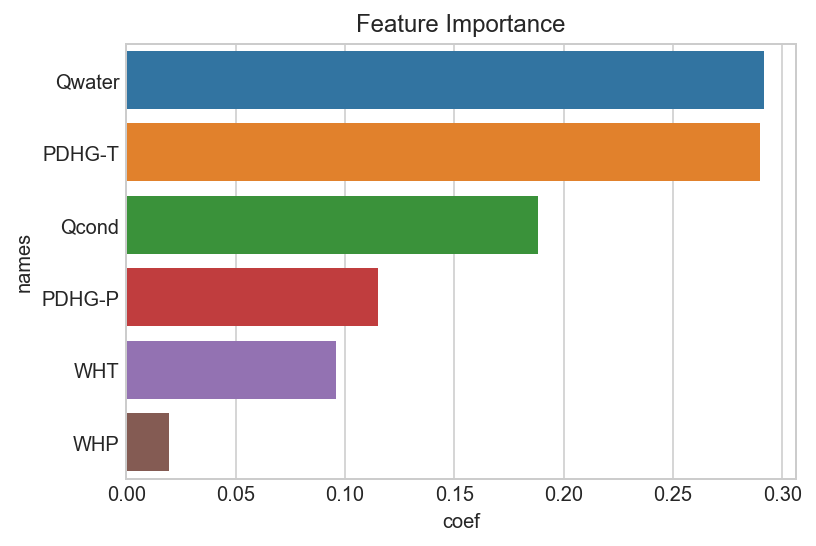

In [21]:
sns.barplot(x='coef', y='names', data=coef_df.sort_values(by='coef',ascending=False))
plt.title('Feature Importance');

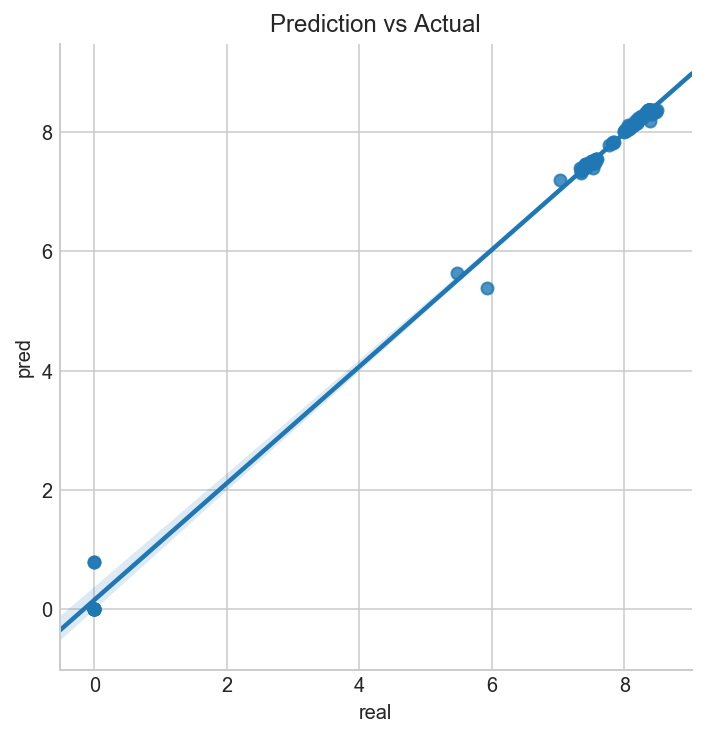

In [22]:
sns.lmplot(x = 'real', y='pred', data=qc)
plt.title('Prediction vs Actual');

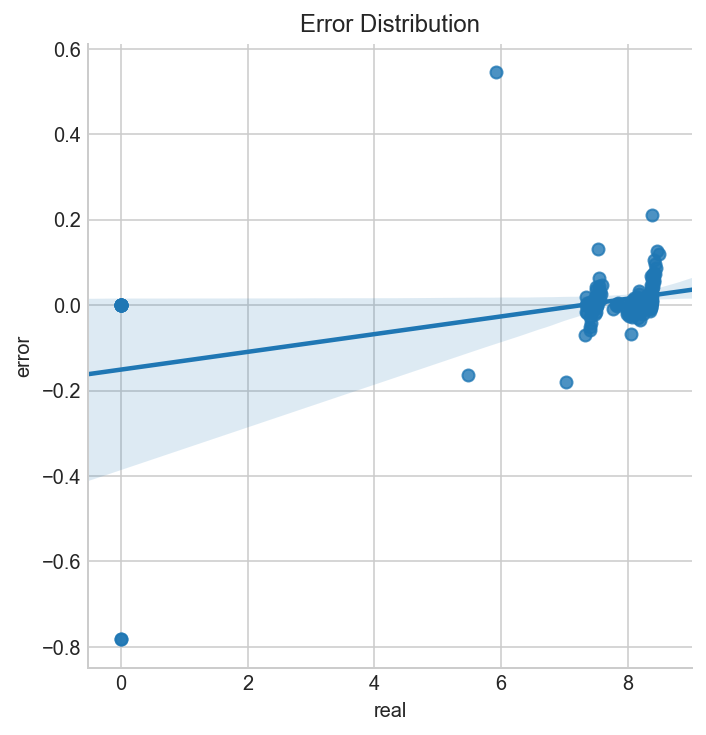

In [23]:
sns.lmplot(x='real', y='error', data=qc)
plt.title('Error Distribution');

/Users/telamon/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


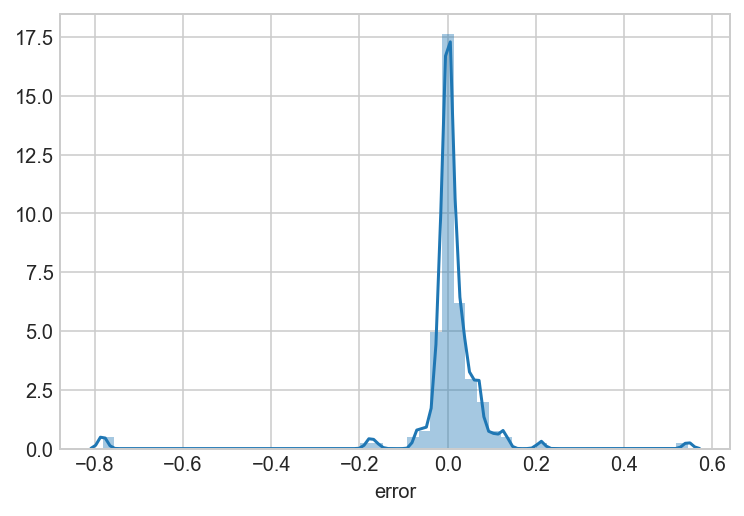

In [24]:
sns.distplot(qc['error']);

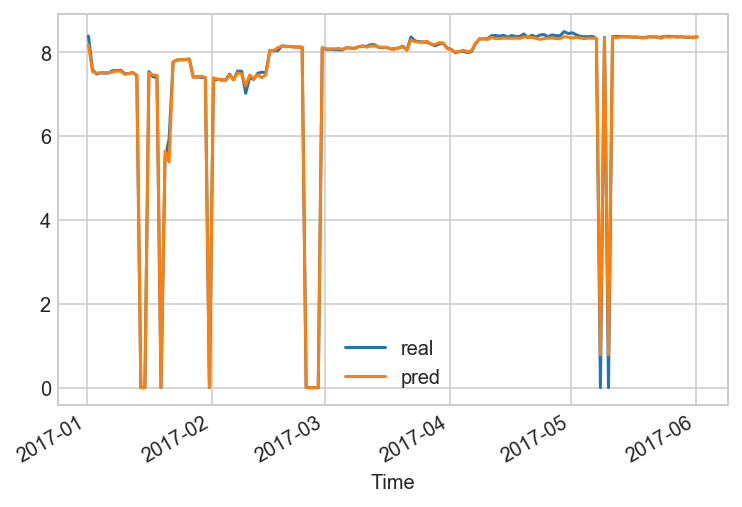

In [25]:
qc.drop(['error'],axis=1).plot();

In [26]:
dfnew = df.copy()

In [27]:
dfnew['CGR'] = df.Qcond / df.Qgas
dfnew['WGR'] = df.Qwater/ df.Qgas

In [28]:
dfnew.head()

,PDHG-P,PDHG-T,WHP,WHT,Qgas,Qcond,Qwater,CGR,WGR
Time,,,,,,,,,
2017-01-01 06:00:00,4788.886719,198.163530,4007.383057,150.251631,70.423714,138.079392,39.740845,1.960695,0.564311
2017-01-02 06:00:00,4990.861328,198.704044,4268.623096,142.566482,57.608315,85.787643,33.254822,1.489154,0.577257
2017-01-03 06:00:00,5003.490234,199.070396,4286.916578,149.122250,56.013939,90.466621,38.221230,1.615073,0.682352
2017-01-04 06:00:00,4984.001465,199.066153,4262.622940,139.118629,56.452805,106.983017,35.447380,1.895088,0.627912
2017-01-05 06:00:00,4978.165527,199.162283,4259.095260,145.619129,56.323635,101.442688,23.743343,1.801068,0.421552


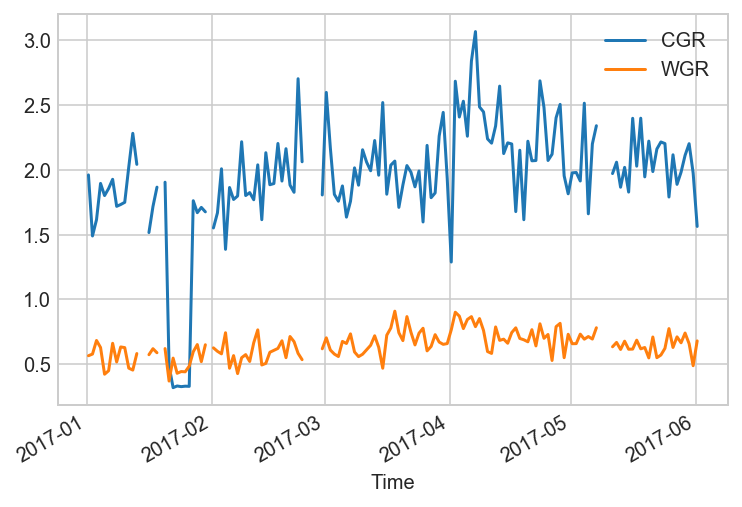

In [29]:
dfnew.CGR.plot()
dfnew.WGR.plot()
plt.legend()
plt.show()

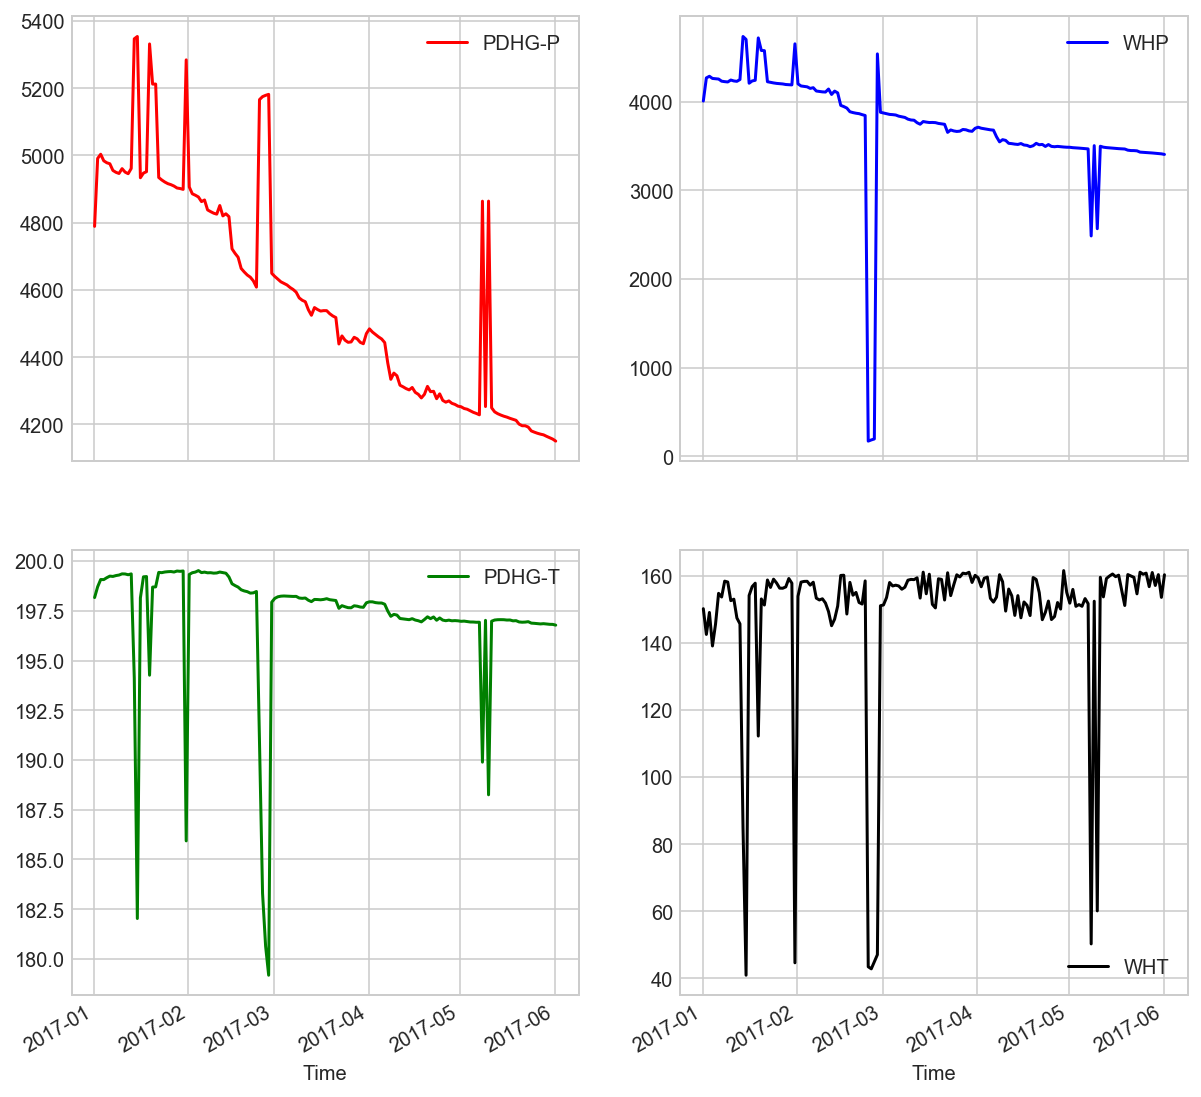

In [30]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10), sharex=True)

dfnew['PDHG-P'].plot(ax=ax[0,0], color='red', legend=True)
dfnew['PDHG-T'].plot(ax=ax[1,0], color='green', legend=True)
dfnew['WHP'].plot(ax=ax[0,1], color='blue', legend=True)
dfnew['WHT'].plot(ax=ax[1,1], color='black', legend=True)
plt.show()

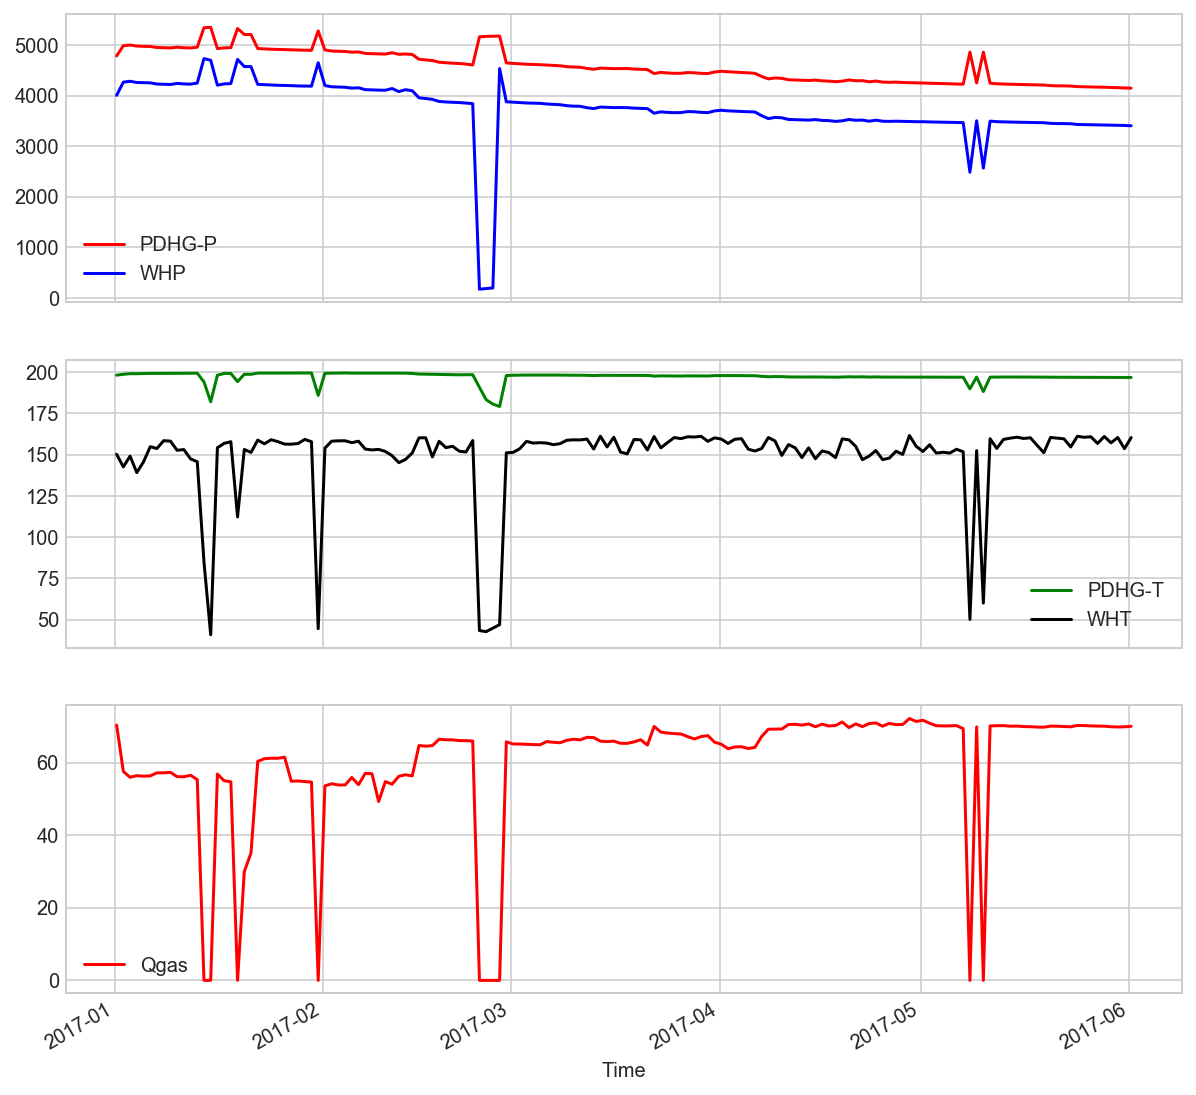

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(10,10), sharex=True)

dfnew['PDHG-P'].plot(ax=ax[0], color='red', legend=True)
dfnew['PDHG-T'].plot(ax=ax[1], color='green', legend=True)
dfnew['WHP'].plot(ax=ax[0], color='blue', legend=True)
dfnew['WHT'].plot(ax=ax[1], color='black', legend=True)
dfnew['Qgas'].plot(ax=ax[2], color='red', legend=True)
plt.show()

In [32]:
# Import data calculated using Prosper
calc = pd.read_csv('data/meter_calc.csv')

In [33]:
# Data preprocessing
calc = calc.drop([0,1])
calc['Time'] = pd.to_datetime(calc['Time'])
calc = calc.set_index('Time')
calc = calc.astype('float')

In [34]:
calc.head()

,Qgas.i
Time,
2017-01-01 06:00:00,70.423714
2017-01-02 06:00:00,59.379181
2017-01-03 06:00:00,49.309915
2017-01-04 06:00:00,59.136544
2017-01-05 06:00:00,56.323635


In [35]:
# Merge the dataframes
merged_df = pd.merge(dfnew, calc, left_index=True, right_index=True)

In [36]:
merged_df.head()

,PDHG-P,PDHG-T,WHP,WHT,Qgas,Qcond,Qwater,CGR,WGR,Qgas.i
Time,,,,,,,,,,
2017-01-01 06:00:00,4788.886719,198.163530,4007.383057,150.251631,70.423714,138.079392,39.740845,1.960695,0.564311,70.423714
2017-01-02 06:00:00,4990.861328,198.704044,4268.623096,142.566482,57.608315,85.787643,33.254822,1.489154,0.577257,59.379181
2017-01-03 06:00:00,5003.490234,199.070396,4286.916578,149.122250,56.013939,90.466621,38.221230,1.615073,0.682352,49.309915
2017-01-04 06:00:00,4984.001465,199.066153,4262.622940,139.118629,56.452805,106.983017,35.447380,1.895088,0.627912,59.136544
2017-01-05 06:00:00,4978.165527,199.162283,4259.095260,145.619129,56.323635,101.442688,23.743343,1.801068,0.421552,56.323635


In [37]:
# merged_df['Qpred'] = ypred
merged_df['Qpred'] = ypred**2

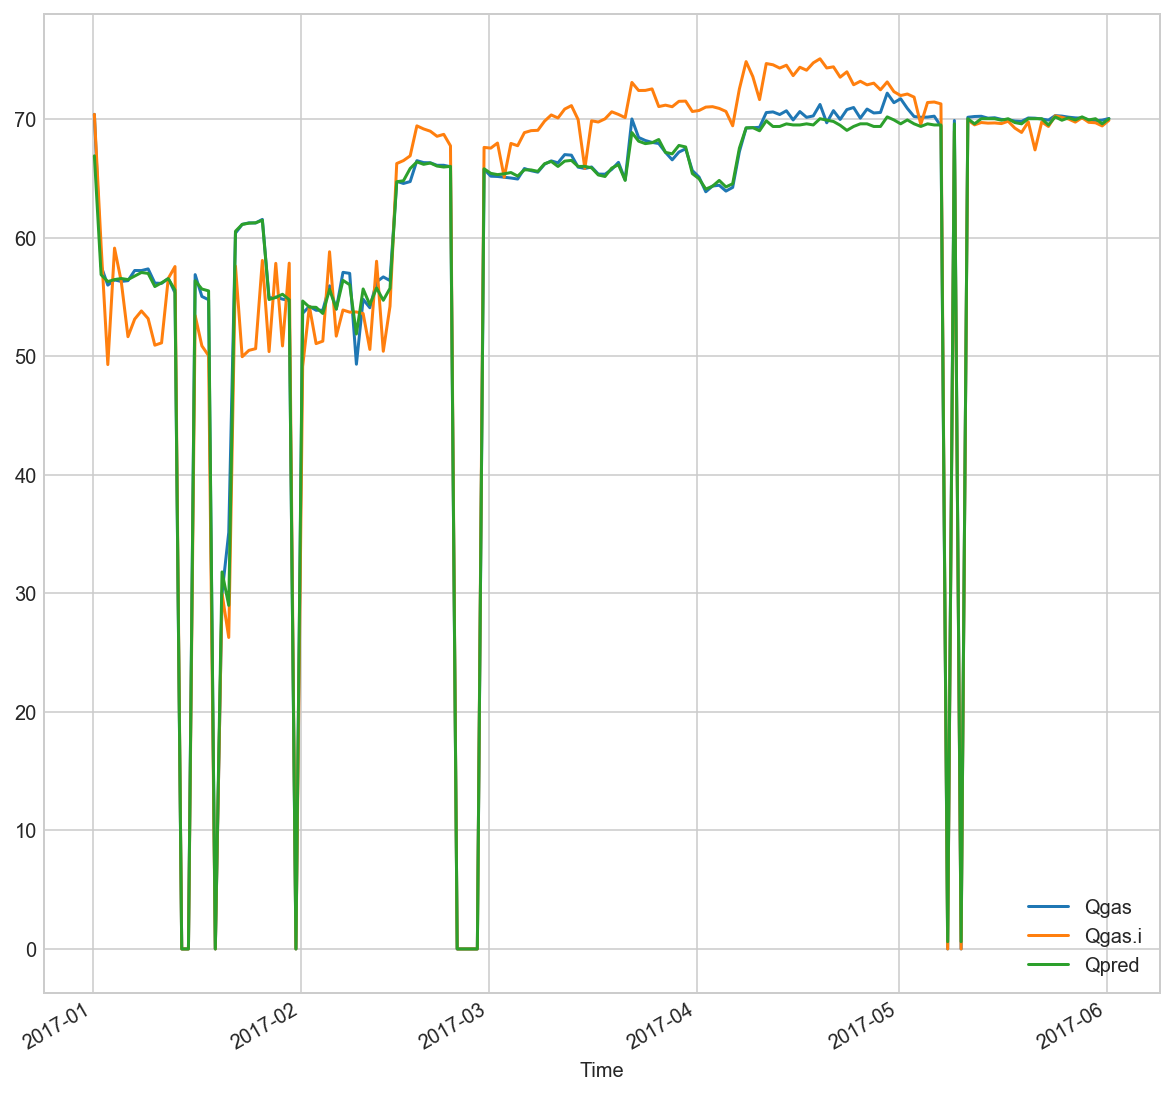

In [38]:
plt.figure(figsize=(10,10))
merged_df['Qgas'].plot(legend=True)
merged_df['Qgas.i'].plot(legend=True)
merged_df['Qpred'].plot(legend=True)

In [39]:
score_prosper = r2_score(merged_df['Qgas'], merged_df['Qgas.i'])
score_rforest = r2_score(merged_df['Qgas'], merged_df['Qpred'])

In [40]:
print('R2 Score')
print('--------')
print('Prosper Prediction: {}'.format(round(score_prosper,3)))
print('Random Forest Prediction: {}'.format(round(score_rforest,3)))

R2 Score
--------
Prosper Prediction: 0.957
Random Forest Prediction: 0.998
